Import statements

In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.3 MB/s eta 0:00:00
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.IMAGENETTE)

In [4]:
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(460),
                   batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = dblock.dataloaders(path, bs=64)

In [5]:

model = xresnet50(n_out=dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Normalization

In [6]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([0.4415, 0.4395, 0.4343], device='cuda:0'),
 TensorImage([0.2874, 0.2814, 0.3093], device='cuda:0'))

In [7]:
def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=size, min_scale=0.75),
                               Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path, bs=bs)

In [8]:
dls = get_dls(64, 224)

In [9]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([-0.1230,  0.0003,  0.0655], device='cuda:0'),
 TensorImage([1.2341, 1.2481, 1.3500], device='cuda:0'))

In [10]:
model = xresnet50(n_out=dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)


Progressive Resizing

In [11]:
dls = get_dls(128, 128)
learn = Learner(dls, xresnet50(n_out=dls.c), loss_func=CrossEntropyLossFlat(),
                metrics=accuracy)
learn.fit_one_cycle(4, 3e-3)


In [12]:

learn.dls = get_dls(64, 224)
learn.fine_tune(5, 1e-3)


Test Time Augmentation

In [13]:
preds,targs = learn.tta()
accuracy(preds, targs).item()

0.8745332360267639

Mixup

the images below shows what it looks like when we take a linear combination of images, as done in Mixup.

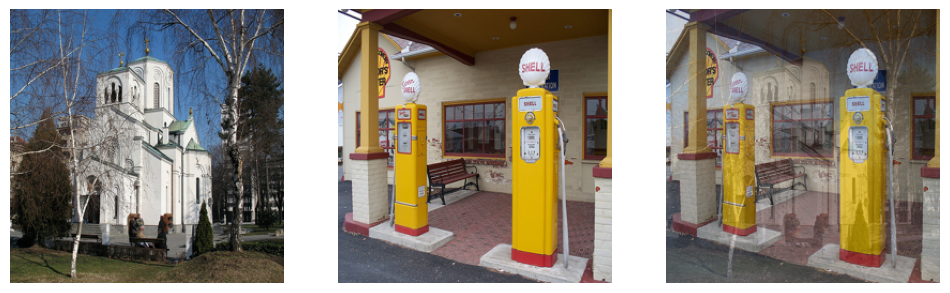

In [14]:
#hide_input
#id mixup_example
#caption Mixing a church and a gas station
#alt An image of a church, a gas station and the two mixed up.
church = PILImage.create(get_image_files_sorted(path/'train'/'n03028079')[0])
gas = PILImage.create(get_image_files_sorted(path/'train'/'n03425413')[0])
church = church.resize((256,256))
gas = gas.resize((256,256))
tchurch = tensor(church).float() / 255.
tgas = tensor(gas).float() / 255.

_,axs = plt.subplots(1, 3, figsize=(12,4))
show_image(tchurch, ax=axs[0]);
show_image(tgas, ax=axs[1]);
show_image((0.3*tchurch + 0.7*tgas), ax=axs[2]);

In [ ]:
model = xresnet50(n_out=dls.c)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(),
                metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)